In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_squared_error, classification_report, root_mean_squared_error, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import svm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.ensemble import RandomForestClassifier
import glob
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold
import seaborn as sns

In [ ]:
file_list = glob.glob('/content/*.xlsx')  # Adjust path if necessary
file_list = sorted(file_list)

In [ ]:
data=pd.read_excel(file_list[0], engine='openpyxl', sheet_name='features')

In [ ]:
data.columns

Index(['Mean', 'STD', 'Modality', 'Skewness', 'Kurtosis', 'IQR', 'SNR', 'MaxI',
       'SumI', 'hu', 'IsReal'],
      dtype='object')

In [ ]:
X = data.dropna().drop(columns=['hu'], axis=1)  # Features
X.columns = X.columns.astype(str)

мультиколлинеарность

In [ ]:
X_corr=X.corr().where(np.triu(np.ones(X.corr().shape), k=1).astype(bool))

In [ ]:
threshold = 0.8

# Get columns where correlation is greater than threshold
highly_correlated_features = []
for i in range(X.shape[1]):
    for j in range(X.shape[1]):
        #print('i=' + str(i))
        #print('j=' + str(j))
        if abs(X_corr.iloc[i, j]) > threshold:
            # Add only one feature per pair to avoid duplicates and ensure we drop only one feature per pair.
            if X.columns[j] not in highly_correlated_features:
                highly_correlated_features.append(X.columns[i])

# Drop these features from original DataFrame
X_reduced = X.drop(highly_correlated_features, axis=1)

print("Features removed:", highly_correlated_features)
print("Remaining features:", list(X_reduced.columns))

Features removed: ['Mean', 'Mean', 'Mean', 'Mean', 'STD', 'STD', 'STD', 'IQR', 'IQR', 'MaxI']
Remaining features: ['Modality', 'Skewness', 'Kurtosis', 'SNR', 'SumI', 'IsReal']


Обучение только на синтетических данных


In [ ]:
X_reduced['IsReal']=X['IsReal']
X_reduced['hu']=data['hu']
synt=X_reduced[X_reduced['IsReal']==0]
real=X_reduced[X_reduced['IsReal']==1]

In [ ]:
synt.head()

,Modality,Skewness,Kurtosis,SNR,SumI,IsReal,hu
0,8,-0.979979,0.260705,5.358751,3442540.17,0,1.0
1,6,-1.030984,0.743856,12.303947,1746381.50,0,1.0
2,9,-1.005506,0.433742,5.824579,3097386.23,0,1.0
3,10,-1.031734,0.543374,5.931983,3182365.71,0,1.0
4,6,-1.030984,0.743856,12.303947,1746381.50,0,1.0


In [ ]:
train=synt.drop(columns=['IsReal'])
test=real.drop(columns=['IsReal'])
train=train.dropna()
test=test.dropna()

In [ ]:
len(synt)

200

In [ ]:
len(test)

32

In [ ]:
shuffled_train_data = train.sample(frac=1, random_state=2026).reset_index(drop=True)
shuffled_real_data=test.sample(frac=1, random_state=2026).reset_index(drop=True)

In [ ]:
X_train=shuffled_train_data.drop(columns='hu')
y_train=shuffled_train_data['hu']
#Масштабирование
scaler=StandardScaler()
X_train_scaled=pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)

X_test=shuffled_real_data.drop(columns='hu')
y_test=shuffled_real_data['hu']
#Масштабирование
X_test_scaled=pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)


In [ ]:
y_train.value_counts()

,count
hu,
0.0,100
1.0,100


In [ ]:
y_test.value_counts()

,count
hu,
0.0,27
1.0,5


LogisticRegression

In [ ]:
logreg=LogisticRegression()
logreg.fit(X_train_scaled, y_train)
y_preds_logreg=logreg.predict(X_test_scaled)
ac_log=accuracy_score(y_test, y_preds_logreg)
print(f'Accuracy: {ac_log}')
pr_log=precision_score(y_test, y_preds_logreg, zero_division=0)
print(f'Precision: {pr_log}')
rc_log=recall_score(y_test,  y_preds_logreg)
print(f'Recall: {rc_log}')
f1_log=f1_score(y_test,  y_preds_logreg)
print(f'F1: {f1_log}')

Accuracy: 0.9375
Precision: 0.7142857142857143
Recall: 1.0
F1: 0.8333333333333334


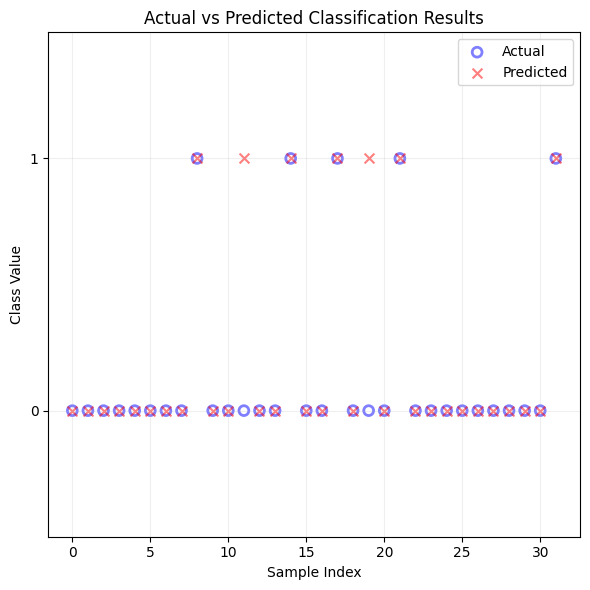

In [ ]:
sample_indices = np.arange(len(y_test))
plt.figure(figsize=(6, 6))
plt.scatter(sample_indices, y_test, color='blue', alpha=0.5, label='Actual', marker='o', s=50, facecolors='none',  # Makes circles hollow
            linewidths=2)
plt.scatter(sample_indices, y_preds_logreg, color='red', alpha=0.5, label='Predicted', marker='x', s=50)

plt.yticks([0, 1], ['0', '1'])
plt.ylim(-0.5, 1.5)
plt.xlabel('Sample Index')
plt.ylabel('Class Value')
plt.title('Actual vs Predicted Classification Results')
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

SVM

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf']  # You can include other kernels like 'poly' if needed
}
grid_search = GridSearchCV(estimator=svm.SVC(), param_grid=param_grid,
                             scoring='f1', cv=5, verbose=1)
grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_preds_best = best_model.predict(X_test_scaled)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'linear'}


In [ ]:
ac_best = accuracy_score(y_test, y_preds_best)
print(f'Accuracy of Best Model: {ac_best}')
pr_best = precision_score(y_test, y_preds_best, zero_division=0)
print(f'Precision of Best Model: {pr_best}')
rc_best = recall_score(y_test, y_preds_best)
print(f'Recall of Best Model: {rc_best}')
f1_best = f1_score(y_test, y_preds_best)
print(f'F1 Score of Best Model: {f1_best}')

Accuracy of Best Model: 0.96875
Precision of Best Model: 0.8333333333333334
Recall of Best Model: 1.0
F1 Score of Best Model: 0.9090909090909091


RandomForestClassifier

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [4, 8, 12],        # Maximum depth of trees
    'min_samples_split': [2, 5],   # Min samples to split
    'min_samples_leaf': [1, 2],    # Min samples per leaf
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),  # Add random_state for reproducibility
                           param_grid,
                           scoring='f1',       # Or another appropriate scoring metric
                           cv=3,              # Number of cross-validation folds
                           verbose=1)          # Displays progress

grid_search.fit(X_train_scaled, y_train)
best_rfc_model = grid_search.best_estimator_
y_preds_rfc = best_rfc_model.predict(X_test_scaled)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [ ]:
ac_log = accuracy_score(y_test, y_preds_rfc)
print(f'Accuracy: {ac_log}')
pr_log = precision_score(y_test, y_preds_rfc, zero_division=0)
print(f'Precision: {pr_log}')
rc_log = recall_score(y_test, y_preds_rfc)
print(f'Recall: {rc_log}')
f1_log = f1_score(y_test, y_preds_rfc)
print(f'F1: {f1_log}')

Accuracy: 0.96875
Precision: 0.8333333333333334
Recall: 1.0
F1: 0.9090909090909091


GradientBoostingClassifier

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],       # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],      # Learning rate
    'max_depth': [3, 4, 5],                 # Max depth of trees
    'min_samples_split': [2, 4],            # Min samples to split
    'min_samples_leaf': [1, 2],             # Min samples per leaf
    'subsample': [0.7, 0.8, 0.9],           # Subsample ratio
    'max_features': ['sqrt', 'log2']       # Max features to consider
}

grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42),  # Add random_state for reproducibility
                           param_grid,
                           scoring='f1',       # Or another appropriate scoring metric
                           cv=3,               # Number of cross-validation folds
                           verbose=1)          # Displays progress

grid_search.fit(X_train_scaled, y_train)
best_gbc_model = grid_search.best_estimator_
y_preds_gbc = best_gbc_model.predict(X_test_scaled)


Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.7}
Precision: 0.8333333333333334


In [ ]:
# Evaluate
ac_log = accuracy_score(y_test, y_preds_gbc)
print(f'Accuracy: {ac_log}')
pr_log = precision_score(y_test, y_preds_gbc, zero_division=0)
print(f'Precision: {pr_log}')
rc_log = recall_score(y_test, y_preds_gbc)
print(f'Recall: {rc_log}')
f1_log = f1_score(y_test, y_preds_gbc)
print(f'F1: {f1_log}')

Accuracy: 0.96875
Precision: 0.8333333333333334
Recall: 1.0
F1: 0.9090909090909091
